In [1]:
import sys
import os
sys.path.append(os.getcwd()+"/../..")

from src import paths
from src import paths
# from src.utils import (load_model_and_tokenizer, 
#                        check_gpu_memory, 
# )

# import argparse

# import torch

# from transformers import TrainingArguments

# from trl import SFTTrainer

# from peft import get_peft_config, get_peft_model

# import json


# from datasets import Dataset

# import bitsandbytes as bnb


In [2]:
MODEL_NAME = "Llama2-MedTuned-13b"
# NEW_MODEL_NAME = args.new_model_name
QUANTIZATION = "4bit"
BATCH_SIZE = 8
LEARNING_RATE = 2e-05
NUM_EPOCHS = 1
PEFT_CONFIG = None
ATTN_IMPLEMENTATION = None
BF16 = False

# Check GPU Memory
check_gpu_memory()

##########################
# Model and Tokenizer
##########################

model, tokenizer = load_model_and_tokenizer(model_name=MODEL_NAME, 
                                            quantization=QUANTIZATION, 
                                            attn_implementation=ATTN_IMPLEMENTATION,
                                            task_type="clm")


model.config.use_cache = False
model.config.pretraining_tp = 1 # recommended for quantized models I think

GPU 0: NVIDIA GeForce RTX 2080 Ti
   Total Memory: 10.75 GB
   Free Memory: 10.18 GB
   Allocated Memory : 0.00 GB
   Reserved Memory : 0.00 GB


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Tokenizer pad token ID: 32000
Tokenizer special tokens: {'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>'}
Model pad token ID: 32000


In [7]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32001, 5120)
    (layers): ModuleList(
      (0-39): 40 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (k_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (v_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (o_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (up_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (down_proj): Linear4bit(in_features=13824, out_features=5120, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): Lla

In [8]:
# Adapted from https://github.com/artidoro/qlora/blob/7f4e95a68dc076bea9b3a413d2b512eca6d004e5/qlora.py#L249
def find_all_linear_names(args, model):
    cls = bnb.nn.Linear4bit
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])


    if 'lm_head' in lora_module_names: # needed for 16-bit
        lora_module_names.remove('lm_head')
    return list(lora_module_names)

In [9]:
find_all_linear_names("bla", model)

['down_proj', 'o_proj', 'k_proj', 'up_proj', 'v_proj', 'q_proj', 'gate_proj']

- https://arxiv.org/abs/2012.14913 talks about number of layers. earlier layers are more for shallow patterns while later layers specialize more in semantic understanding. In paper a model with 16 layers they said layers 1-9 were for shallow detection (so half).
    - 40 Decoder Layers; target the first 10 should be enough.
- Original Lora Paper (https://arxiv.org/abs/2106.09685). "Note that putting all the parameters in Wq or Wk results in significantly lower performance, while adapting both Wq and Wv yields the best result (so adapting Key and Query).
- QLoRa Paper: "we find that the most critical LoRA hyperparameter is how many LoRA adapters are used in total and that LoRA on all linear transformer block layers are required to match full finetuning performance. Other LoRA hyperparameters, such as the projection dimension r, do not affect performance" (https://arxiv.org/pdf/2305.14314.pdf)
- As the QLoRa Paper is newer I would go with this one (so target all linear layers) and set the rank lower than I originally did.
    - Find all linear layers, and target these
    - Set Rank to 4
- https://medium.com/@fartypantsham/what-rank-r-and-alpha-to-use-in-lora-in-llm-1b4f025fd133 suggests setting rank = alpha if you don't want to completely change your model. In my case I want to make as little changes as possible. So I try this.

Thus config:

config = {
        "peft_type": "LORA",
        "r": 4,
        "lora_alpha": 4,
        "lora_dropout": 0.1,
        "bias":"none",
        "task_type":"CAUSAL_LM",
        "target_modules": ['down_proj', 'o_proj', 'k_proj', 'up_proj', 'v_proj', 'q_proj', 'gate_proj'],
        "layers_to_transform" : list(range(0, 5)),
    }


In [11]:


##########################
# Data
##########################

dataset = Dataset.load_from_disk(os.path.join(paths.DATA_PATH_PREPROCESSED, "text-finetune/kisim_diagnoses"))

##########################
# Specifiations
##########################

# adapted from: https://towardsdatascience.com/fine-tune-your-own-llama-2-model-in-a-colab-notebook-df9823a04a32

# Output directory where the model predictions and checkpoints will be stored
output_dir = os.path.join(paths.MODEL_PATH, "results")

# Number of training epochs
num_train_epochs = NUM_EPOCHS

# Enable fp16/bf16 training
fp16 = False
bf16 = BF16

# Batch size per GPU for training
per_device_train_batch_size = BATCH_SIZE

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = LEARNING_RATE

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule (constant a bit better than cosine)
lr_scheduler_type = "constant"

# Number of training steps (overrides num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 50

# Log every X updates steps
logging_steps = 50

# Maximum sequence length to use
max_seq_length = 128

# Pack multiple short examples in the same input sequence to increase efficiency
packing = True

# LoRA attention dimension
lora_r = 64

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

In [13]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32001, 5120)
    (layers): ModuleList(
      (0-39): 40 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (k_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (v_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (o_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (up_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (down_proj): Linear4bit(in_features=13824, out_features=5120, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): Lla

In [28]:
config = {
        "peft_type": "LORA",
        "r": 4,
        "lora_alpha": 4,
        "lora_dropout": 0.1,
        "bias":"none",
        "task_type":"CAUSAL_LM",
        "target_modules": ['down_proj', 'o_proj', 'k_proj', 'up_proj', 'v_proj', 'q_proj', 'gate_proj'],
        "layers_to_transform" : list(range(5)),
    }

PEFT_CONFIG = get_peft_config(config)

In [29]:
PEFT_CONFIG

LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type='CAUSAL_LM', inference_mode=False, r=4, target_modules={'down_proj', 'o_proj', 'k_proj', 'up_proj', 'v_proj', 'q_proj', 'gate_proj'}, lora_alpha=4, lora_dropout=0.1, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=[0, 1, 2, 3, 4], layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={}, use_dora=False)

In [30]:
peft_model = get_peft_model(model, PEFT_CONFIG)

In [31]:
peft_model.print_trainable_parameters()

trainable params: 5,867,520 || all params: 13,021,742,080 || trainable%: 0.045059408825274476


In [27]:
print(peft_model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32001, 5120)
        (layers): ModuleList(
          (0-9): 10 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=5120, out_features=5120, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=5120, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=5120, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer): Linear4bit(

In [ ]:

##########################
# Training
##########################


# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    gradient_checkpointing=gradient_checkpointing,
    gradient_checkpointing_kwargs={'use_reentrant':False},
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
)

# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=PEFT_CONFIG,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
)

print("Starting Training")

# Train
trainer.train()

print("Finished Training")

##########################
# Saving
##########################

if NEW_MODEL_NAME is None:
    NEW_MODEL_NAME = MODEL_NAME + "_finetuned"

print("Saving Model at:", paths.MODEL_PATH/NEW_MODEL_NAME)
trainer.save_model(paths.MODEL_PATH/NEW_MODEL_NAME)

print("Saving Tokenizer at:", paths.MODEL_PATH/NEW_MODEL_NAME)
tokenizer.save_pretrained(paths.MODEL_PATH/NEW_MODEL_NAME)

print("Saving training logs at:", paths.MODEL_PATH/NEW_MODEL_NAME/"log_history.pt")
torch.save(trainer.state.log_history, paths.MODEL_PATH/NEW_MODEL_NAME/"log_history.pt")

# Training Progress

Loss is CrossEntropy Loss with labels being the tokens shifted by one, so token is predicted by n preceeding tokens. See Source code of LLama:
https://github.com/huggingface/transformers/blob/main/src/transformers/models/llama/modeling_llama.py#L1217

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import colors as mcolors
import torch

In [3]:
logs_1024 = torch.load(paths.MODEL_PATH/"Llama2-MedTuned-13b-1024-lora/log_history.pt")
logs_512 = torch.load(paths.MODEL_PATH/"Llama2-MedTuned-13b-512-lora/log_history.pt")

In [4]:
def plot_loss_over_epochs(loss_data, title="Loss Over Epochs"):
    # Convert the data to a DataFrame
    df = pd.DataFrame(loss_data)

    viridis_cmap = plt.get_cmap('viridis_r')
    cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)

    # Extract a subset of colors from the "viridis" colormap
    start_index = 120  # Start index of colors to include
    end_index = 200 # End index of colors to include
    subset_colors = viridis_cmap(np.linspace(start_index / 255, end_index / 255, end_index - start_index + 1))

    # Create a custom colormap using the subset of colors
    custom_cmap = mcolors.ListedColormap(subset_colors)
    custom_cmap = sns.color_palette("light:#5A9", as_cmap=True)


    # Create the plot
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 6))
    ax = sns.lineplot(x='epoch', y='loss', data=df, marker='o', color = custom_cmap(400))

    # Add labels and title
    ax.set(xlabel='Epoch', ylabel='Loss', title=title)

    # Show the plot
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

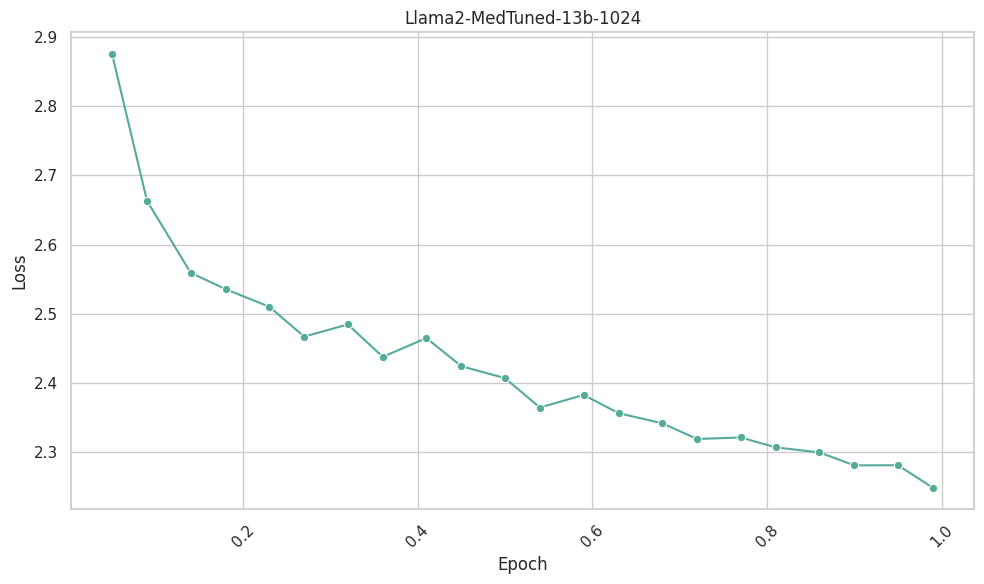

In [5]:
plot_loss_over_epochs(logs_1024[:-1], title="Llama2-MedTuned-13b-1024")

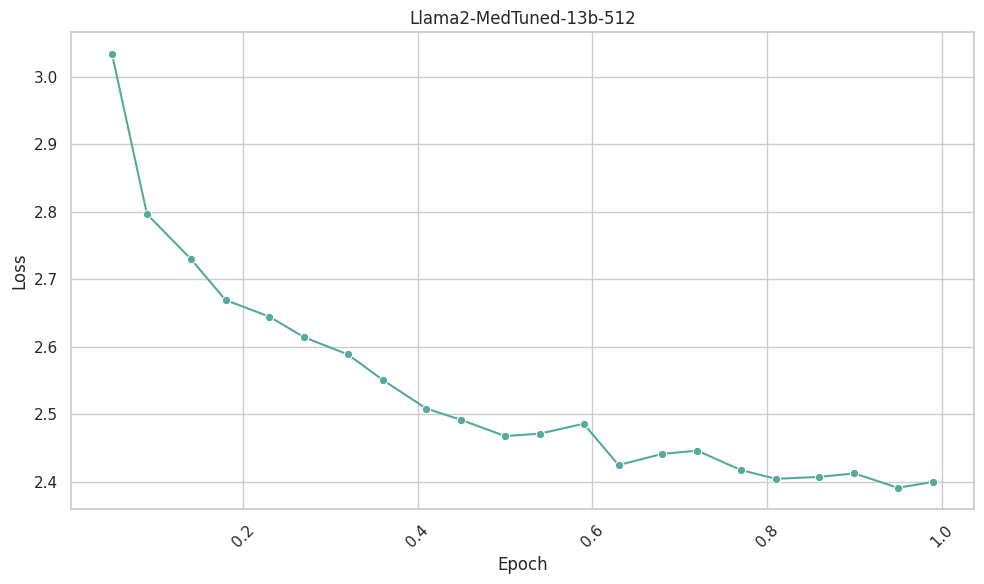

In [6]:
plot_loss_over_epochs(logs_512[:-1], title="Llama2-MedTuned-13b-512")